# Classify snow-covered area (SCA) in PlanetScope imagery: full pipeline

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Planet account with access to PlanetScope imagery through the NASA CSDA contract. Sign up __[here](https://www.planet.com/markets/nasa/)__.
- Area of Interest (AOI) shapefile: where snow will be classified in each image. 
- PlanetScope 4-band image collection over the AOI. Download images using `planetAPI_image_download.ipynb` or through [PlanetExplorer](https://www.planet.com/explorer/). 
- Google Earth Engine (GEE) account: used to pull DEM over the AOI. Sign up for a free account [here](). 


### Outline:
__0. Setup__ paths in directory, AOI file location - _modify this section!_

__1. Mosaic images__ captured in the same hour

__2. Adjust image radiometry__ using median surface reflectance at the top perentile of elevations

__3. Classify SCA__ and use the snow elevations distribution to estimate the seasonal snowline

__4. Estimate snow line__ and snow line elevations

----------

## 0. Setup

#### Define paths in directory, image file extensions, and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [5]:
##### MODIFY HERE #####
# -----Path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

# -----Paths in directory
site_name = 'SCascade'
# path to images
im_path = base_path+'../study-sites/'+site_name+'/imagery/PlanetScope/2016-2021/'
# path to AOI including the name of the shapefile
AOI_fn = base_path+'../../GIS_data/RGI_outlines/'+site_name+'_RGI.shp'
# path for output images
out_path = im_path+'../'
# path for output figures
figures_out_path = im_path+'../../../figures/'

# -----Image file extensions (for mosaicing)
ext = 'SR_clip'

# -----Determine settings
plot_results = True # = True to plot figures of results for each image where applicable
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max blue SR < 0.8
crop_to_AOI = True # = True to crop images to AOI before calculating SCA
save_outputs = True # = True to save SCA images to file
save_figures = True # = True to save SCA output figures to file

#######################

# -----Import packages
import os
import numpy as np
import glob
import subprocess
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt, dates
import rasterio as rio
from scipy import stats
import pandas as pd
import geopandas as gpd
import sys
import time
import ee
import pickle

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

# -----Load AOI as geopandas.GeoDataFrame
AOI = gpd.read_file(AOI_fn)

# -----Set paths for output files
im_mosaic_path = out_path+'mosaics/'
im_adj_path = out_path+'adjusted-filtered/'
im_classified_path = out_path+'classified/'

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

#### Query GEE for DEM

In [6]:
DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)

Downloading:   0%|          | 0.00/8.06k [00:00<?, ?iB/s]

## 1. Mosaic images by date

Mosaic all images captured within the same hour to increase area coverage of each image over the AOI. Images captured in different hours are more likely to have drastic variations in illumination. Adapted from code developed by Jukes Liu. 

If you have `plot_results` set to `True`, I suggest using the output figures to filter out images, such as those that are completely saturated (some small regions of saturation are okay), barely cover the AOI, or have thick cloud cover over a large portion of the AOI. Place unusable images into a separate folder (e.g., `unusable_images`) or otherwise remove them from the `mosaics/` folder before proceeding to step __2.__ below. This takes extra time, but will help to improve the resulting SCA and snow line elevation time series. 

Note that images with no data over the AOI are skipped in this step. Issues with illumination or radiometry will be further filtered and adjusted in the next step.  

In [ ]:
# -----Load file names with proper extension
os.chdir(im_path)
im_fns = glob.glob('*' + ext + '*')
im_fns.sort() # sort chronologically

# ----Mosaic images by date
f.mosaic_ims_by_date(im_path, im_fns, ext, im_mosaic_path, AOI, plot_results)

## 2. Adjust image radiometry

Mitigate issues related to varying illumination and general radiometry by first creating a polygon(s) representing the of an area within the AOI that is likely covered with snow year-round using the upper 30th percentile of elevations. The polygon(s) will then be used to stretch the image, assuming the median surface reflectance value within the polygon is equal to that predicted for snow, and that the darkest point in the image has a surface reflectance of 0. Images with no real data values within the AOI or in the polygon(s) will be skipped. 

In [ ]:
# -----Read image mosaic file names
os.chdir(im_mosaic_path)
im_mosaic_fns = glob.glob('*.tif')
im_mosaic_fns.sort()

# -----Create a polygon(s) of the top 20th percentile elevations within the AOI
polygon, im_fn, im = f.create_top_elev_AOI_poly(AOI_UTM, im_mosaic_path, im_mosaic_fns, DEM)
# plot
if plot_results:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(np.dstack([im.data[2], im.data[1], im.data[0]]), 
               extent=(np.min(im.x), np.max(im.x), np.min(im.y), np.max(im.y)))
    AOI_UTM.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='AOI')
    count=0 # count used to only display one polygon in legend
    for geom in polygon.geoms:
        xs, ys = geom.exterior.xy
        if count==0:
            ax.plot([x for x in xs], [y for y in ys], color='orange', label='polygon(s)')
        else:
            ax.plot([x for x in xs], [y for y in ys], color='orange', label='_nolegend_')
        count+=1            
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    ax.set_title(im_fn)
    fig.legend(loc='upper right')
    fig.tight_layout()
    plt.show()
    
# -----Loop through images
for im_mosaic_fn in im_mosaic_fns:
    
    # load image
    print(im_mosaic_fn)
    
    # adjust radiometry
    im_adj_fn = f.adjust_image_radiometry(im_mosaic_fn, im_mosaic_path, polygon, im_adj_path, skip_clipped, plot_results)
                     
    print('----------')
    print(' ')

## 3. Classify SCA

In [ ]:
# -----Read adjusted image file names
os.chdir(im_adj_path)
im_adj_fns = glob.glob('*.tif')
im_adj_fns.sort()

# start timer
t1 = time.time()

# -----Load image classifier and feature columns
clf_fn = base_path+'inputs-outputs/PS_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/PS_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Loop through images
# image datetimes
im_dts = [] 
# DataFrame to hold stats summary
df = pd.DataFrame(columns=('site_name', 'datetime', 'im_elev_min', 'im_elev_max', 'snow_elev_min', 'snow_elev_max', 
                           'snow_elev_median', 'snow_elev_10th_perc', 'snow_elev_90th_perc'))
for im_adj_fn in im_adj_fns:

    # extract datetime from image name
    im_dt = np.datetime64(im_adj_fn[0:4] + '-' + im_adj_fn[4:6] + '-' + im_adj_fn[6:8]
                          + 'T' + im_adj_fn[9:11] + ':00:00')
    im_dts = im_dts + [im_dt]

    # classify snow
    im_classified_fn, im_adj = f.classify_image(im_adj_fn, im_adj_path, clf, feature_cols, crop_to_AOI, AOI_UTM, im_classified_path)  

# -----Stop timer
print('Time elapsed: '+str(np.round((time.time()-t1)/60, 2))+' minutes')


## 4. Estimate seasonal snow line and snow line elevations

/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1452: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1519: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm_adj = H_snow_est_elev_adj / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


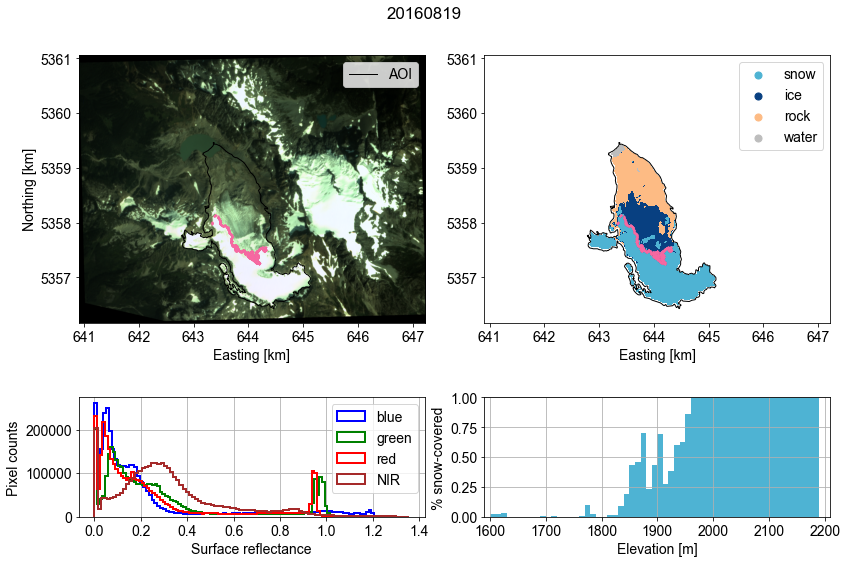

figure saved to file


/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1452: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1519: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm_adj = H_snow_est_elev_adj / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


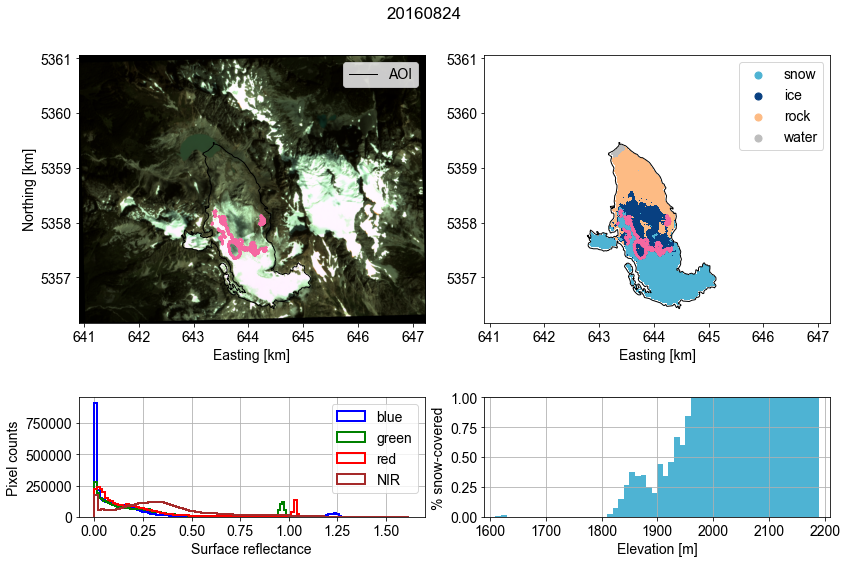

figure saved to file


/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1452: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1519: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm_adj = H_snow_est_elev_adj / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


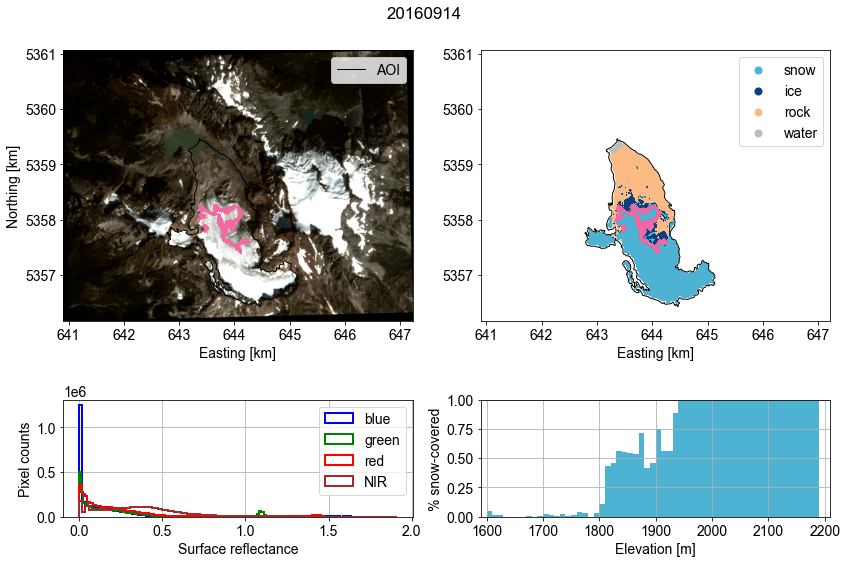

figure saved to file


/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1452: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1519: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm_adj = H_snow_est_elev_adj / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


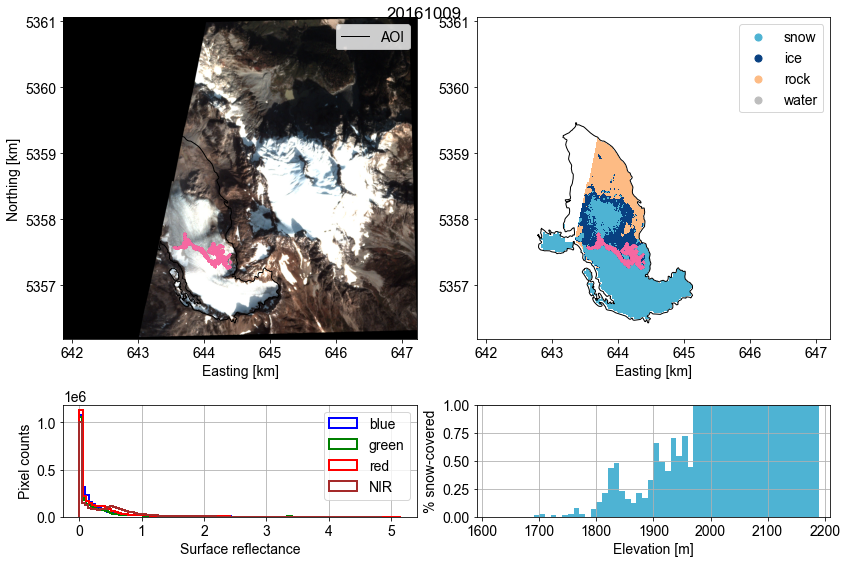

figure saved to file


/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1452: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/ps_pipeline_utils.py:1519: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm_adj = H_snow_est_elev_adj / H_DEM


IndexError: index -1 is out of bounds for axis 0 with size 0

In [7]:
# -----Read adjusted image file names
os.chdir(im_adj_path)
im_adj_fns = glob.glob('*.tif')
im_adj_fns.sort()

# -----Read classified image file names
os.chdir(im_classified_path)
im_classified_fns = glob.glob('*.tif')
im_classified_fns.sort()

# -----Create directory for output figures if it does not exist
if save_figures and os.path.exists(figures_out_path)==False:
    os.mkdir(figures_out_path)
    print('made directory for output figures:' + figures_out_path)

# -----Intialize variables
sl_est_elev_medians = [] # median snow line elevation estimates
im_dts = [] # image datetimes

# -----Loop through classified image filenames
for im_adj_fn, im_classified_fn in list(zip(im_adj_fns, im_classified_fns)):
    
    # extract datetime from image file name
    im_date = im_adj_fn[0:8]
    im_dt = np.datetime64(im_adj_fn[0:4] + '-' + im_adj_fn[4:6] + '-' + im_adj_fn[6:8]
                          + 'T' + im_adj_fn[9:11] + ':00:00')
    im_dts = im_dts + [im_dt] # save to list
    
    # estimate snow line
    fig, ax, sl_est, sl_est_elev = f.delineate_snow_line(im_adj_fn, im_adj_path, im_classified_fn, im_classified_path, AOI_UTM, DEM)
    
    # calculate median snow line elevation
    sl_est_elev_median = np.nanmedian(sl_est_elev)
    sl_est_elev_medians = sl_est_elev_medians + [sl_est_elev_median] # save to list
    
    plt.show()

    # save figure
    if save_figures:
        fig.savefig(figures_out_path+'PS_' + im_date + '_sl_elevs.png', dpi=300, facecolor='white', edgecolor='none')
        print('figure saved to file')
        
# -----Plot median snow line elevations
fig2, ax2 = plt.subplots(figsize=(6,8))
ax2.plot(im_dts, sl_est_elev_medians, '.b')
ax2.set_xlabel('Image capture date')
ax2.set_ylabel('Median snow line elevation [m]')
ax2.grid()
fig2.suptitle(site_name + ' Glacier snow line elevations')
plt.show()

# save figure
if save_figures:
    fig2.savefig(figures_out_path + site_name + '_median_sl_elevs.png', dpi=300, facecolor='white', edgecolor='none')
    print('figure saved to file')

### _Optional:_ Compile individual figures into a .gif and delete individual figures

In [ ]:
from PIL import Image as PIL_Image
from IPython.display import Image as IPy_Image

# -----Make a .gif of output images
os.chdir(figures_out_path)
fig_fns = glob.glob('PS_*_SCA.png') # load all output figure file names
fig_fns.sort() # sort chronologically
# grab figures date range for .gif file name
fig_start_date = fig_fns[0][3:-15] # first figure date
fig_end_date = fig_fns[-1][3:-15] # final figure date
frames = [PIL_Image.open(im) for im in fig_fns]
frame_one = frames[0]
gif_fn = ('PS_' + fig_start_date[0:8] + '_' + fig_end_date[0:8] + '_SCA.gif' )
frame_one.save(figures_out_path + gif_fn, format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
print('GIF saved to file:' + figures_out_path + gif_fn)

# -----Display .gif
IPy_Image(filename=figures_out_path+gif_fn)

# -----Clean up: delete individual figure files
files = os.listdir(figures_out_path)
for file in files:
    if ('PS_' in file) and ('_SCA.png' in file):
        os.remove(os.path.join(figures_out_path, file))
print('Individual figure files deleted.')